# Preparing node and edge lists with Python code
This notebook will walk you through some Python code to read information from teh .csv files we downloaded from WMR (or otherwise prepared by scraping links from WMR or cleaning data in OpenRefine). 

I've tried to explain what's happening at each step of the way, both in the text cells and in comments in the code cells. You don't have to understand every bit of syntax to understand the gist of what's happening here, but do feel free to pose questions about the code in Slack or on Zoom. (And bear in mind, as always, that this probably isn't the most efficient way to write this code!)

Because you might be working with the data I provided or you might be working with data you downloaded from WMR, yourself, you'll need to pay close attention to file paths, file names, and column headings/field names: you might need to modify the code below to match your data. I've tried to call attention to places where you'll need to couble check to make sure the code matches the data you have.

At the end, we'll download our node and edge lists as .csv files: I've tried to set things up so that the column headings from this workbook match those in the notebook that performed the same task using Google Sheets: that way, you can use your data either to create a visualization in code or using the online service Kumu.

## 1 - Connect to Google Drive and set path name

In [ ]:
#Code cell 1.1

from google.colab import drive
drive.mount('/gdrive')

The values you set for this next cell depend on where you've put the data that you're working with from WMR. Adjust the value of `source_directory` to match the location of your .csv files. (In the cells below, I've included the `wmr_full_search_results` folder in the file names, so you don't necessarily have to add that here.)

In [ ]:
#Code cell 1.2

#If you're working with data from WMR that you uploaded to the data_my folder, 
#use this path
source_directory = '/gdrive/MyDrive/rbs_digital_approaches_2021/data_my/'

#If you're using the sample data I provided in the data_class folder, comment out
#line 3 and uncomment line 7
#source_directory = '/gdrive/MyDrive/rbs_digital_approaches_2021/data_class/

## 2 - Import the `csv` package for reading and writing .csv files
`csv` is not the only package that can work read and write .csv files. You're  likely to see lots of Python code online using the `pandas` module for this task. I've stuck with `csv` in this example simply because I've used that package a lot longer than I have `pandas` and so am more familiar with the syntax.

In [ ]:
#Code cell 2

import csv

## 3 - Begin building node list
We could probably build up our node list in fewer steps, but for the sake of clarity, I'm first going to deal with books and then with borrowers. Then we'll combine the two into a larger set of nodes.

In each case, we'll read information from one .csv file to get our basic information, then read a different .csv file to add the links to the WMR site. 

### 3.a.i - Basic book information
We begin by creating an empty dictionary to hold information about our books. For each entry in the dictionary, our key will be an integer and our value will be another dictionary with key/value pairs, initially for 'label' and 'wmr_number' (we'll add 'link' in the next step).

The decision to use arbitrary integers as the identifier may seem strange, since WMR provides accession numbers for books. I opted to do it this way because of something I noticed about the *patron* identifiers at WMR: one patron identifer can be attached to multiple Borrower names (members of the same household are often associated with the same patron number—wives seems to have borrowed under their husband's numbers, and children under their parents'). Because I wanted to be able to keep track of distinct Borrowers (and not just patron numbers), I needed a different identifier. Since I was going to have to make up new identifiers for borrowers, I decided to do the same thing for books. 

You may need to adjust the file that gets opened in line 14, depending on where your .csv files are located, and you may need to adjust the field names in lines 30 and 31 to match what's in the first row of your .csv file.

In [ ]:
#Code cell 3.a.i.1

#Create an empty dictionary to hold information about books
books = {}

#We need identifiers for all of our records. We'll just use sequential numbers,
#beginning at 1. This creates a variable to serve as the key for each new entry
#in the dictionary. We'll increase the value of i by one with each record we 
#create.
i = 1

#Open a .csv file in readable mode, and refer to it using the variable name 
#"bookfile"
with open(source_directory + 'wmr_full_search_results/book.csv', 'r') as bookfile :
  
  #Create an instance of the csv module's DictReader (dictionary reader) that 
  #reads the bookfile file, setting parameters for what character serves as the 
  #delimiter and what character denotes a text string. Call this instance of
  #DictReader "bookreader"
  bookreader = csv.DictReader(bookfile, delimiter=',', quotechar='"')
  
  #Iterate through the rows in the .csv file
  for row in bookreader :
    
    #Create an entry in the books dictionary with the value of i as the key, and
    #a nested dictionary as the value. The nested dictionary has a 'label' key 
    #(whose value is built up by combining the contents of the author column and
    #the title column); and a 'wmr_number' key (whose value comes from the 
    #Accession # column)
    books[i] = {'label': row['Author_name_portion'].strip() + '. ' + row['Title'],
                'wmr_number': row['Accession #']}
    
    #Increase the value of i (in effect, i = i+1)
    i += 1

Let's see what we have so far...

In [ ]:
#Code cell 3.a.i.2

for book_id, book_values in books.items() :
  print(book_id, book_values)

### 3.a.ii - Adding links for the books
Now we open the .csv file of links to WMR that we scraped with the Scraper extension. We use the WMR accession number to match the information in this .csv file with the information we already have in the `books` dictionary and add that link to the nested dictionary of values for each book.

The code in this cell behaves pretty much exactly like one we've seen before, so I've kept my comments to a minimum.

You may need to adjust the file path and file name in line 3 to match the location of your .csv files, and you may need to adjust the field names in lines 15 and 17 to match what's in the first row of your .csv file.

In [ ]:
#Code cell 3.a.ii.1

with open(source_directory + 'wmr_full_search_results/wmr_book_links.csv', 'r') as booklink_file :
  booklink_reader = csv.DictReader(booklink_file, delimiter=',', quotechar='"')
  for row in booklink_reader :
    #Get the accession number from the .csv file
    wmr_number = row['accession_number']
    
    #Start a second for loop to iterate through the keys and values in the books
    #dictionary
    for book_id, book_values in books.items() :
      
      #If the value of 'wmr_number' in the books dictionary matches the wmr_number
      #in this row of the .csv file...
      if book_values['wmr_number'] == wmr_number :
        
        #Add a new key ('link') with the value of the book_url column in the 
        #current row of the .csv file
        book_values['link'] = row['book_url']

Let's see how the `books` dictionary has been updated.

In [ ]:
#Code cell 3.a.ii.2

for book_id, book_values in books.items() :
  print(book_id, book_values)

### 3.b.i - Getting a list of borrowers
We'll now turn to the `transaction.csv` file, which will allow us to get information both about borrowers and about loan transactions.

The `patron.csv` file seems like a more obvious choice for getting information about borrowers. Because of the issue I noted above about more than one Borrower being associated with a patron number, though, I decided to go straight to the `transaction.csv` file, instead: that file gives us all of the different borrowers' names, but also links them to a patron record at WMR.

(Note that, if you haven't done it yet, you'll need to delete the first row of the `transaction.csv` file as dowenloaded from WMR: we want to make sure that the first row in the file gives the column names.)

You may have to adjust the file path or file name in line 7 to match your data.

In order to be able to match these borrowers to patron records in the next step, I'm building up a two-part identifier for each borrower that pairs their name (a string of text) with the patron number. The data type of this two-part identifier is a "tuple," which is a bit like a list, but with some differences. (Note how the tuples in this code cell are enclosed in parentheses, rather than square brackets.) 

For my purposes, one important difference is that tuples are immutable: whereas a list can be changed (sorted, elements added or deleted), a tuple always stays the same. By storing this "fingerprint" as a tuple, I could be more confident that I was going to keep track of all unique combinations of borrower names and patron numbers.

We're storing these tuples in a list called `unique_borrowers`, but we're checking to be sure we don't already have that tuple in our list before adding it.

Since I'm reading the `transaction.csv` file, anyway, I'm also storing information about the loans at the same time. Transactions is another list that stores a series of tuples, but this time the tuples have three elements: the same borrower name and patron id that are being stored in `unique_borrowers`, but also the WMR number for the book. Unlike `unique_borroewrs`, I'm not making any effort to limit this list to distinct values: if a borroewr borrowed the same book twice, we'll end up with two entries in the `transactions` list.

In [ ]:
#Code cell 3.b.i.1

#Create empty lists to store information
unique_borrowers = []
transactions = []

with open(source_directory + '/wmr_full_search_results/transaction.csv', 'r') as transaction_file :
  transaction_reader = csv.DictReader(transaction_file, delimiter=',', quotechar='"')
  for row in transaction_reader :
    borrower_name = row['Borrower Name']
    patron_number = row['Patron #']
    accession_number = row['Accession #']
    
    #Check to see if the tuple of (borrower_name, patron_number) is already in
    #the list of unique_borroewrs. If not, add it
    if (borrower_name, patron_number) not in unique_borrowers :
      unique_borrowers.append((borrower_name, patron_number))
    
    #Add a three-tuple of (borrower_name, patron_number, accession_number) to 
    #the transactions list
    transactions.append((borrower_name, patron_number, accession_number))

Let's see our list of unique borrowers. 

In [ ]:
#Code cell 3.b.i.2

for unique_borrower in unique_borrowers :
  print(unique_borrower)

And the first 50 items in our list of transactions (though we won't do anything with this just yet).

In [ ]:
#Code cell 3.b.i.3

for transaction in transactions[0:50] :
  print(transaction)

### 3.b.ii - Basic borrower information
Just as we did with our books, we'll create an empty dictionary to hold information about our borrowers and begin filling it in. 

We couldn't do this directly from the .csv file, because we needed to assemble a list of borrower names and patron ids first. Therefore, we'll begin building our dictionary by iterating through the list of `unique_borrowers`.

For the numeric id, we could just have continued with the value of `i`, which is still set at wherever it was when we finished creating ids for the books. Because I was paranoid that I'd end up messing up the value of `i` as I tinkered with this notebook, though, this cell creates a new variable, `j` and figures out its initial value by getting all the keys of the `books` dictionary, making sure they're sorted, and then choosing the last one (that's what the -1 index does). That gets the highest numerical key in the `books` dictionary, to which we can then add one to make sure that we don't have any duplicate keys.

In [ ]:
#Code cell 3.b.ii

#Create an empty dictionary for borrower information
borrowers = {}

#Get the highest value among the keys in the books dictinary, then add
#1 to get a starting value for keys in the borrowers dictionary
highest_i = sorted(books.keys())[-1]
j = highest_i + 1

#Iterate through the list of unique borrowers
for unique_borrower in unique_borrowers :
  
  #Create an entry in the borrowers dictionary with the value of j as 
  #the key, and a nested dictionary with label and wmr_number as its
  #keys
  borrowers[j] = {'label': unique_borrower[0],
                  'wmr_number': unique_borrower[1]}
  
  #Increase the value of j (i.e., j = j+1)
  j += 1

#Let's see the basic borrower information
for borrower_id, borrower_values in borrowers.items() :
  print(borrower_id, borrower_values)

### 3.b.iii - Add links to borrowers dictionary
Open the .csv file with links to the patron records scraped from WMR. The code in this cell works just as the coe in code cell 3.a.ii.1.

You may need to adjust the file path or file name in line 3 to match the location of your .csv file, and yo umay need to change the field names in lines 6 and 9 to match what's in the first row of your .csv file.

In [ ]:
#Code cell 3.b.iii.1

with open(source_directory + 'wmr_full_search_results/wmr_patron_links.csv', 'r') as patronlink_file :
  patronlink_reader = csv.DictReader(patronlink_file, delimiter=',', quotechar='"')
  for row in patronlink_reader :
    wmr_number = row['patron_number']
    for borrower_id, borrower_values in borrowers.items() :
      if borrower_values['wmr_number'] == wmr_number :
        borrower_values['link'] = row['patron_url']

Let's see how the `borrowers` dictionary has been updated.

In [ ]:
#Code cell 3.b.iii.2

for borrower_id, borrower_values in borrowers.items() :
  print(borrower_id, borrower_values)

### 3.b.iv - Adding more information about borrowers (in theory)
Because we have the links back to the borrower records at WMR, we can retrieve information about borrowers that's not included in the .csv files we downloaded. Let's have a look at one of those records to see the kind of information that's there:


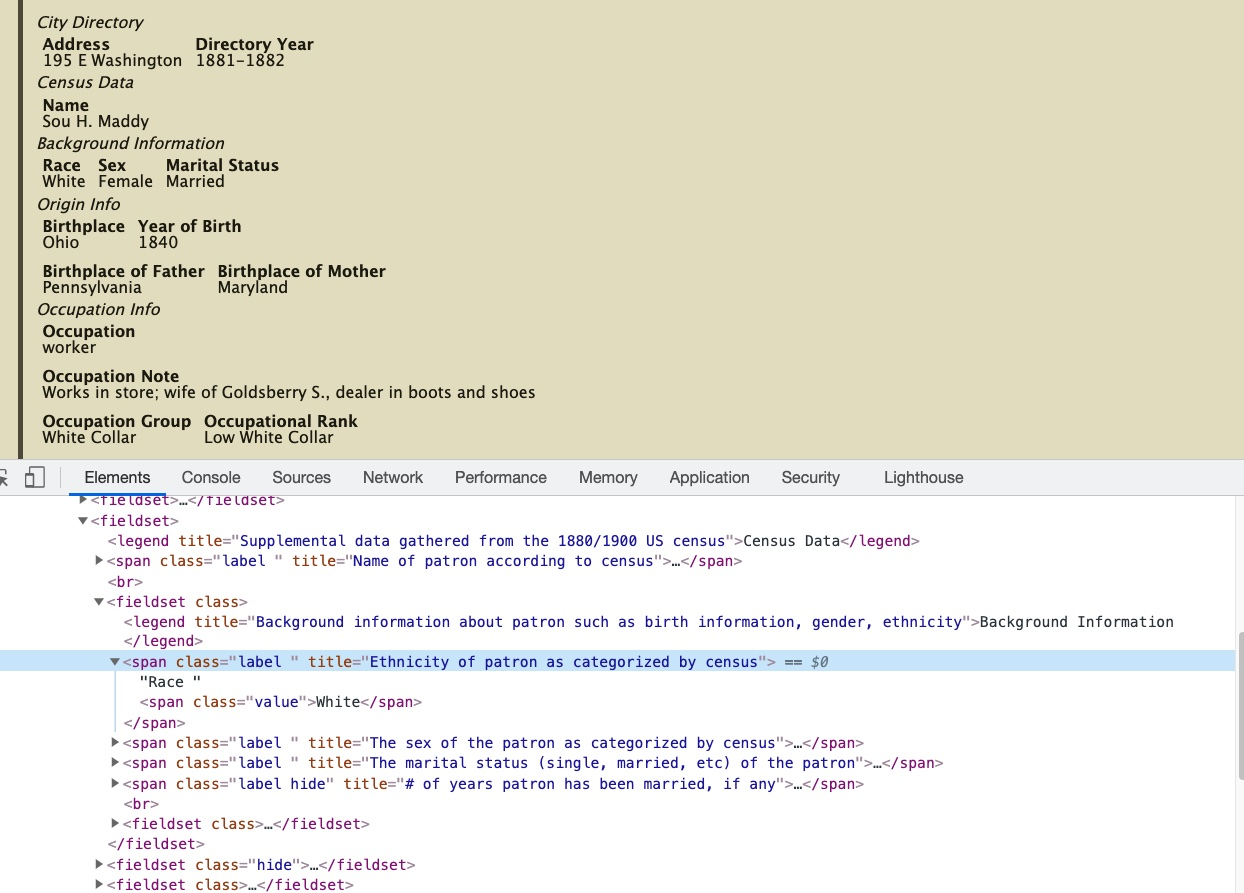

It's possible for us to get all of this data by retrieving the information using the URL we have and selecting portions of that data using a technique very similar to the selection by XPath that we used with the Scraper Chrome extension.

Scraping a site in this way can require some careul consideration: you don't want to hammer the site's server (it's rude, in the first place, and can also get your script locked out from the data you want), and you also need to account for problems that may arise. The code below offers a very simple implementation of web scraping that should get us what we want.

**Please don't actually run this cell, though!** I've put it here as a rough example, but it would take more than 20 minutes to finish running and wouldn't necessarily deal gracefully with missing data. You can run the cell below it to get a sense of how the code would work.

In [ ]:
#Code cell 3.b.iv.i

additional_borrower_info = {}

#Import packages for web scraping
import requests
from bs4 import BeautifulSoup
import time

#Work through our borrowers dictionary, getting the URL for each
for borrower_id, borrower_values in borrowers.items() :
  if 'link' in borrower_values :
    link = borrower_values['link']
    additional_borrower_info.setdefault(borrower_id, {})
  #Retrieve the data from the link using the requests package
    r = requests.get(link)
    print('Retrieving information about ' + borrower_values['label'])
    #Parse the content of the web page using BeautifulSoup. 
    #Yes, that's really what it's called.
    soup = BeautifulSoup(r.content)

    #Find various span elements in the web page by searching for the contents of 
    #their title attributes
    race = soup.find('span', title='Ethnicity of patron as categorized by census').span.get_text()
    gender = soup.find('span', title='The sex of the patron as categorized by census').span.get_text()
    marital_status = soup.find('span', title='The marital status (single, married, etc) of the patron').span.get_text()
    occupational_status = soup.find('span', title='Inferred occupational rank based on type of job').span.get_text()

    #Add the information we just gleaned as new keys in the nested dictionary
    #of values for each borrower
    additional_borrower_info[borrower_id]['race'] = race
    additional_borrower_info[borrower_id]['gender'] = gender
    additional_borrower_info[borrower_id]['marital_status'] = marital_status
    additional_borrower_info[borrower_id]['occupational_status'] = occupational_status

    #Wait 2 seconds before sending the next request
    time.sleep(2)


In [ ]:
#Import packages for web scraping
import requests
from bs4 import BeautifulSoup
import time

#Work through our borrowers dictionary, getting the URL for each
ids = ['36', '1056', '659', '2146']
for id in ids :
  link = 'https://lib.bsu.edu/wmr/patron_record.php?ID=' + id
  
  #Retrieve the data from the link using the requests package
  r = requests.get(link)
  
  #Parse the content of the web page using BeautifulSoup. 
  #Yes, that's really what it's called.
  soup = BeautifulSoup(r.content)
  name = soup.find('span', title='Name of patron-- in Last, First format -- according to ledger entry').span.get_text()
  print('Retrieving information about ' + name)
  #Find various span elements in the web page by searching for the contents of 
  #their title attributes
  if soup.find('span', title='Ethnicity of patron as categorized by census') :
    race = soup.find('span', title='Ethnicity of patron as categorized by census').span.get_text()
  else :
    race = ''
  if soup.find('span', title='The sex of the patron as categorized by census') :
    gender = soup.find('span', title='The sex of the patron as categorized by census').span.get_text()
  else : 
    gender = ''
  if soup.find('span', title='The marital status (single, married, etc) of the patron') :
    marital_status = soup.find('span', title='The marital status (single, married, etc) of the patron').span.get_text()
  else :
    marital_status = ''
  if soup.find('span', title='Inferred occupational rank based on type of job') :
    occupational_status = soup.find('span', title='Inferred occupational rank based on type of job').span.get_text()
  else :
    occupational_status = ''

  #Add the information we just gleaned as new keys in the nested dictionary
  #of values for each borrower
  if race != '' :
    print('--Race: ' + race)
  if gender != '' : 
    print('--Gender: ' + gender)
  if marital_status != '' :
    print('--Marital Status: ' + marital_status)
  if occupational_status != '' :
    print('--Occupational Level: ' + occupational_status)

  #Wait 2 seconds before sending the next request
  time.sleep(2)

### 3.c - Putting all our nodes together
This cell creates a new empty dictionary, then copies the values of the `books` and `borrowers` dictionaries into it, adding a field for `type` (i.e. "Book" or "Borrower") to each node as we go.

In [ ]:
#Code cell 3.c.1

#Create an empty dictionary to hold all nodes
nodes = {}

#Work through the key/value pairs in the books dictionary, adding a 
#corresponding key/value pair to the nodes dictionary. For each entry
#in the nodes dictionary that's created in this way, add a new key 
#('type') to the nested dictionary, and set its value to "Book"
for book_id, book_values in books.items() :
  nodes[book_id] = book_values
  nodes[book_id]['type'] = 'Book'

#Do likewise for borrowers
for borrower_id, borrower_values in borrowers.items() :
  nodes[borrower_id] = borrower_values
  nodes[borrower_id]['type'] = 'Borrower'


Let's see our combined dictionary.

In [ ]:
#Code cell 3.c.2

for node_id, node_values in nodes.items() :
  print(node_id, node_values)

## 4 - Creating the edges list
Now we come back to the `transactions` list that we created in passing at 3.b.i, above and use it to create our edge list.

Unfortunately, we can't just use the three-tuples in the `transactions` list, but have to use the information in them to get the sequential ids from our nodes dictionary. I have a feeling that the way I'm doing this is not very efficient, but it seems to work well enough.

In [ ]:
#Code cell 4.1

#Create an empty list to hold the edges
edges = []

#Iterate through the list of transactions
for transaction in transactions :

  #Iterate through the keys and values in the nodes dictionary
  for node_id, node_values in nodes.items() :
    
    #If the first item in the transaction tuple matches the label of the item in 
    #the nodes dictionary AND the second item in the transaction tuple matches
    #the wmr_number of the item in the nodes dictionary, use the key of that 
    #entry in the nodes dictionary (referred to here as node_id) as the borrower
    if transaction[0] == node_values['label'] and transaction[1] == node_values['wmr_number'] :
      borrower = node_id

    #If the third item in the transaction tuple matches the wmr_number of the 
    #item in the nodes dictionary, use the key of that entry in the nodes dictionary
    #as the book
    if transaction[2] == node_values['wmr_number'] :
      book = node_id
  
  #Append a tuple of (borrower, book) to the edges list
  edges.append((borrower, book))

#Print the first fifty items in the edges list
for edge in edges[0:50] :
  print(edge)

## 5 - Saving our values to .csv files
We'll write the information from our `nodes` dictionary and `edges` list to .csv files so you can move on to the next notebook you choose: either constructing a visualization with Python code or uploading the .csv files to Kumu for visualization.

In [ ]:
#Code cell 5.1

#Set the path of the output directory
output_directory = '/gdrive/MyDrive/rbs_digital_approaches_2021/output/'

#Create a list of fieldnames to use as column headings for our .csv file
fieldnames = ['ID', 'Label', 'Type', 'WMR_Number', 'Link']

#Open a new writable file and create an instance of csv DictWriter
with open(output_directory + 'wmr_nodes.csv', 'w') as nodes_out :
  nodes_writer = csv.DictWriter(nodes_out, delimiter=',', quotechar='"', fieldnames=fieldnames)
  
  #Write a header row
  nodes_writer.writeheader()

  #Work through the nodes dictionary. For each entry, create a variable row that
  # maps values in the dictionary to columns in the .csv file we're writing.
  for node_id, node_values in nodes.items() :
    
    #Not all nodes have links. Test if that field is present. If so, use it.
    #If not, treat link as an empty string
    if 'link' in node_values :
      link = node_values['link']
    else :
      link = ''
    
    row = {'ID': node_id,
           'Label': node_values['label'],
           'Type': node_values['type'],
           'WMR_Number': node_values['wmr_number'],
           'Link': link}
    
    #Write the row to the file
    nodes_writer.writerow(row)

Now for the edges list

In [ ]:
#Code cell 5.2

fieldnames = ['From', 'To']

with open(output_directory + 'wmr_edges.csv', 'w') as edges_out :
  edges_writer = csv.DictWriter(edges_out, delimiter=',', quotechar='"', fieldnames=fieldnames)
  edges_writer.writeheader()
  for edge in edges :
    row = {'From': edge[0],
           'To': edge[1]}
    edges_writer.writerow(row)

## 6 - Next steps
From here, you can either proceed to the notebook that will load these .csv files to create and visualize a network graph using Python code, or you can upload to Kumu and experiment with that online service. Your node and edge lists should work in either setting.